<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [16]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [85]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data_2filters.csv'
column_names = ['Mean', 'Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff', 'Total Area', 'Kurtosis', 'Power', '99% Bandwidth', 'Top Bandwidth Frequency', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (4471, 14)
Recuento de instancias por clase:
State
1    2739
0    1732
Name: count, dtype: int64


In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto
raw_dataset.tail() # muestra las últimas 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [86]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [47]:
# Extracción de subconjuntos: bloque de código original original
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

In [87]:
#del train_dataset['Power']
#del test_dataset['Power']
#del train_dataset['Total Area']
#del test_dataset['Total Area']
#a= train_dataset.pop('Power')
#b=train_dataset.pop('Total Area')
#c=test_dataset.pop('Power')
#d=test_dataset.pop('Total Area')
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3576, 13)
Formato del dataset de test: (895, 13)


In [88]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3576.0,1.344764,2.487041,1.297531e-04,0.236080,0.421001,1.016103,16.534123
Median,3576.0,1.347568,2.503174,2.290229e-17,0.234549,0.421427,1.008861,17.077204
Standard Dev,3576.0,0.130753,0.357733,2.161042e-04,0.004728,0.023330,0.098886,6.554894
Max Value,3576.0,1.549452,2.724238,1.918076e-03,0.278929,0.469363,1.276192,17.567782
Min Value,3576.0,1.120945,2.296944,-3.577987e-02,0.142515,0.326396,0.703080,16.115192
Standard Dev 1st diff,3576.0,0.016618,0.035635,7.380049e-05,0.000642,0.003363,0.014598,0.703398
Median 1st diff,3576.0,-0.000236,0.001205,-1.514828e-02,0.000000,0.000000,0.000000,0.011229
Standard Dev 2nd diff,3576.0,0.011050,0.020861,7.830884e-05,0.000528,0.002634,0.011383,0.398887
Total Area,3576.0,160.028501,295.992250,1.557038e-02,28.075638,50.115419,120.706845,1975.154566
Kurtosis,3576.0,3.986693,5.048037,1.021172e+00,1.929308,2.545961,4.062169,113.818091


### 3.2. Normalización y estandarización de todos los datos

In [89]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3576, 13)
Formato del dataset de test: (895, 13)


In [67]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3576.0,1.192186e-17,1.0,-0.540656,-0.445785,-0.371431,-0.132149,6.107401
Median,3576.0,1.192186e-17,1.0,-0.538344,-0.444643,-0.369987,-0.135311,6.283877
Standard Dev,3576.0,5.662883e-17,1.0,-0.364901,-0.352288,-0.300289,-0.089082,17.957932
Max Value,3576.0,-7.649859e-17,1.0,-0.568061,-0.466377,-0.396474,-0.100307,5.879931
Min Value,3576.0,-9.835533e-17,1.0,-0.503593,-0.425970,-0.345916,-0.181922,6.527911
Standard Dev 1st diff,3576.0,4.967441e-17,1.0,-0.464259,-0.448327,-0.371958,-0.056671,19.272456
Median 1st diff,3576.0,-5.563534e-17,1.0,-12.379372,0.195624,0.195624,0.195624,9.517386
Standard Dev 2nd diff,3576.0,5.861580e-17,1.0,-0.525925,-0.504361,-0.403412,0.015978,18.591575
Total Area,3576.0,6.457673e-17,1.0,-0.540598,-0.445798,-0.371338,-0.132847,6.132343
Kurtosis,3576.0,-2.732092e-17,1.0,-0.587460,-0.407561,-0.285404,0.014952,21.757247


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [91]:
from keras import Sequential, layers, activations

def build_model_best(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

def build_model_ELU(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Conv1D(9, 4, padding='valid'))
  model.add(layers.BatchNormalization())
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_ELU(train_size)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)                   │ (None, 13, 27)              │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 13, 27)              │             108 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_4 (ELU)                          │ (None, 13, 27)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 11, 22)              │           1,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 11, 22)              │              88 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_5 (ELU)                          │ (None, 11, 22)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 8, 18)               │           1,602 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 8, 18)               │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_6 (ELU)                          │ (None, 8, 18)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 5, 9)                │             657 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 5, 9)                │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_7 (ELU)                          │ (None, 5, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 45)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 22)                  │           1,012 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,483 (21.42 KB)

 Trainable params: 5,331 (20.82 KB)

 Non-trainable params: 152 (608.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [96]:
EPOCHS = 700
history = model.fit(normed_train_data, train_labels, batch_size=350,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [97]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
695,0.745455,0.760563,0.500383,0.761589,0.851852,0.677374,0.756944,0.696737,0.717622,0.775229,695
696,0.746154,0.760563,0.503511,0.748431,0.883191,0.628492,0.756944,0.714409,0.694064,0.697248,696
697,0.737413,0.760563,0.502920,0.761186,0.833618,0.660615,0.756944,0.711755,0.693387,0.793578,697
698,0.743706,0.760563,0.493541,0.756784,0.858120,0.646648,0.756944,0.708325,0.687885,0.768349,698
699,0.737762,0.760563,0.497303,0.737140,0.890028,0.639665,0.756944,0.720959,0.706977,0.697248,699


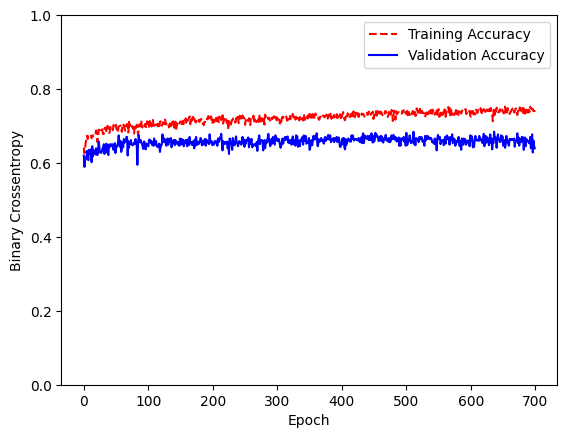

In [98]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [99]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.6279 - f1_score: 0.7595 - loss: 0.7838 - precision: 0.6923 - recall: 0.7062
Test accuracy: 62.79%
Test loss: 0.784


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


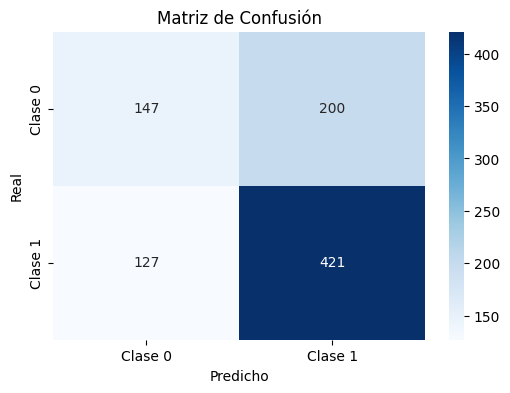

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.54      0.42      0.47       347
     Clase 1       0.68      0.77      0.72       548

    accuracy                           0.63       895
   macro avg       0.61      0.60      0.60       895
weighted avg       0.62      0.63      0.62       895



In [79]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
